In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
data_dir = '../kaggle_data/'

In [3]:
kaggle_train = data_dir+'train.csv'

In [44]:
df_orig = pd.read_csv(kaggle_train)
import copy
df = copy.copy(df_orig)
#df_train,df_cv = train_test_split(pd.read_csv(kaggle_train))

In [5]:
N = len(df[df['target']==0])
N

27300

In [6]:
#df_train.sortlevel()

# df['null_count'] = df.isnull().sum(axis=1)
# df = df[df['null_count']<10]
# df.drop('null_count',axis=1,inplace=True)

In [7]:
# BALANCE THE CLASSES

mask1 = df['target']==1
mask0 = df['target']==0
#N = 5000
df = pd.concat([df[mask1].sample(N), df[mask0].sample(N)])

In [8]:
# df = df.sample(frac=0.1)
# len(df.index)

In [9]:
person_id = df['ID']
y_df = df['target']
y_df.index = df['ID']
category_features = ['v24','v30','v31','v47','v52','v56','v66',\
                     'v74','v75','v79','v91','v107','v110','v112','v113','v125']
complicated_category_features = ['v3','v22','v52','v71']
integer_features = ['v38','v62','v72','v129']

non_numeric = ['ID','target']+category_features+complicated_category_features
numeric_features = []
for c in df.columns:
    if c not in non_numeric:
        numeric_features.append(c)


In [10]:
# df[integer_features]

In [11]:
df_cat = df[category_features]
df_cat.index = df['ID']

In [12]:
# # OPTIONAL: FILL NANS WITH MODE OF GROUP
# for c in df_cat.columns.values:
#     df_cat[c] = df_cat[c].fillna(df_cat[c].mode())
df_cat = pd.get_dummies(df_cat,dummy_na=True)

In [13]:
# for c in df_cat.columns.values:
#     print(c)
#     print(df_cat[c].value_counts())

In [14]:
df_num = df[numeric_features]


In [15]:
for c in df_num.columns.values:
    df_num[c] = df_num[c].fillna(df_num[c].mean())
df_num.index = df['ID']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
X_df = df_num.merge(df_cat,how='inner',left_index=True,right_index=True)


In [17]:
X_df['Target'] = y_df.values

In [18]:
df_train,df_test = train_test_split(X_df)

In [19]:
y_df_train = df_train['Target']
X_df_train = df_train.drop(['Target'],axis=1)
y_df_test = df_test['Target']
X_df_test = df_test.drop(['Target'],axis=1)


In [20]:
X_train = X_df_train.values
y_train = y_df_train.values
X_test = X_df_test.values
y_test = y_df_test.values

# X_train = X_df_train[imp_features].values
# y_train = y_df_train.values
# X_test = X_df_test[imp_features].values
# y_test = y_df_test.values

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC

In [22]:
#clf = LogisticRegression(C=0.01)
#clf = RandomForestClassifier(max_depth=13)
clf = XGBC(learning_rate=0.02,n_estimators=300,max_depth=7)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

TRAINING SET:


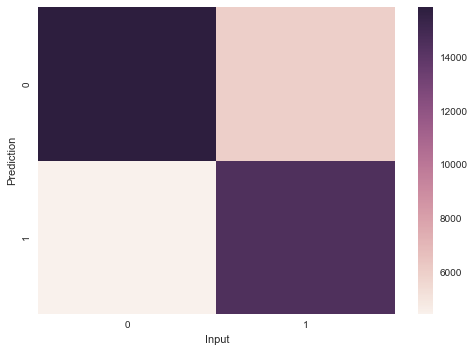

TEST SET:


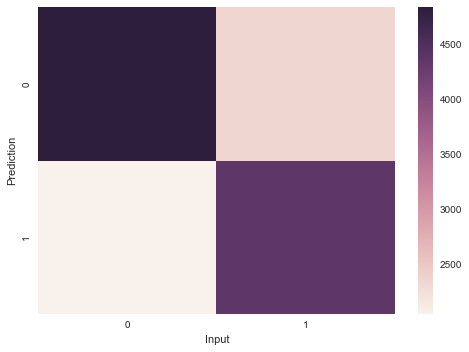

In [23]:
# Predictions on training
print("TRAINING SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(clf.predict(X_train),y_train))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

# Predictions on test
print("TEST SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(clf.predict(X_test),y_test))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

In [24]:
clf.score(X_test,y_test)

0.67626373626373626

In [48]:
perc_balance = 1.0*len(df_orig[df_orig['target']==1].index) / (len(df_orig[df_orig['target']==0].index)+\
                                                    len(df_orig[df_orig['target']==1].index))

In [51]:
chance_0 = clf.predict_proba(X_test)[:,0]


zeros = np.where(chance_0>np.percentile(chance_0,perc_balance*100))
ones  = np.where(chance_0<=np.percentile(chance_0,perc_balance*100))

unbalanced_set = np.ones(len(X_test))
unbalanced_set[zeros]=0

TEST SET:


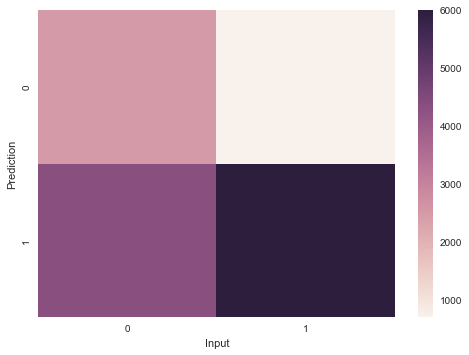

[[2537  723]
 [4372 6018]]


In [52]:


# Predictions on test
print("TEST SET:")
import seaborn as sns
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(unbalanced_set,y_test))
ax.set_xlabel('Input')
ax.set_ylabel('Prediction')
plt.show()

print(confusion_matrix(unbalanced_set,y_test))

In [54]:
1.0*np.sum(unbalanced_set==y_test) / np.size(y_test)

0.62673992673992673

In [25]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
cols = X_df_train.columns.values
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")

lim = -1
plt.bar(range(X_train.shape[1])[:lim], importances[indices][:lim],
       color="r", yerr=std[indices][:lim], align="center")
plt.xticks(range(X_train.shape[1])[:lim], np.array(cols)[indices[:lim]])
plt.xlim([-1, max(np.arange(X_train.shape[1])[:lim])])
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'feature_importances_'

In [ ]:
# imp_features = cols[importances>0.002]

In [ ]:
plt.hist(y_train)